<a href="https://colab.research.google.com/github/vknalluri/64061/blob/main/ConvNet_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1.	Train (1000), Validation (500) and Test (500) (Optimizer: RMSprop)

a)	Training accuracy of the model is highest (99.05%) and the loss is minimum (0.0312) at 26 out of 30 epochs. As such both the metrics are affected after 26 epochs.
b)	Validation accuracy has not shown much improvement after about 15 epochs , topping a maximum of 75%, and the loss actually started to going up after 15 epochs. Apparently, the model at this juncture is overfitting (high training accuracy than that of validation and test , perhaps, due to the small sample and complex model.

We can use callbacks function to early stop the model training after model starts witnessing performance degradation. Of course, there are many other methods/calls in the callbacks function to save the model/model weights after each epoch (to retreive the model in case of a crash) etc.

c)	Test accuracy is 76%.

1.	A) Train (1000), Validation (500) and Test (500) (Optimizer: adam)


Training, Validation and test accuracy achieved 100%,75.20% and 76% respectively. Training accuracy topped at 23 epochs.
     

2.	Train (2000), Validation (500) and Test (500) with image augmentation (zoom, rotation and horizontal flip) and Optimizer: adam

a)	Training accuracy of the model is highest (85.10%)) at 29 out of 30 epochs. 
b)	Validation accuracy has topped out at 83.8% at 25 epochs. Validation and training accuracy are almost in tandem.
c)	Surprisingly, Test accuracy is at 85.8%, higher than the training accuracy. This could be due to several factors such as tight regularization, size of test sample or could be its a sheer accident.

3.	Train (4000), Validation (500) and Test (500) with image augmentation (zoom, rotation and horizontal flip) and Optimizer: adam

a)	Training accuracy of the model is highest 90.29%)) at 29 out of 30 epochs. 
b)	Validation accuracy has topped out at 89.3% at 28 epochs. Validation and training accuracy are almost in tandem.
c)	Surprisingly, Test accuracy is at 90.7%, higher than the training accuracy by a slight margin again. 

4. All the three scenarios above with Pretrained model. 1(A) is not included:

a)  Training accuracy topped out at 98.65% at 11th epoch(either dropped or negligible improvement after 11th epoch) and Validation accuracy is 97.50% at 13th epoch and Test Accuracy at 97.90%
b)  Training and validation accuracy are at 96.5 and test accuracy is 97%
c)  Training and validation accuracy are at 98.2 and 98 % respectively and test accuracy is 98.1%


Note: Changing the strides to 2, in the given below script its none which is equal to a default value of 1, and max pooling size which maintains the spatial invariance & speed & over fit issues may have an impact on the accuracyn of the model. Furthermore, having a bigger training and test sample would effect the accuracy of the model. Of course, changing the filter size also would effect the model performance, for example, making the kernel/filter size from 3X3 to 5X5 may induce more complexity into the model and may either possitively or negatively effect the model performance based on other factors such as size of the data set and other complexities and hyper parameters in the model.

Update: 03/28/2022 - All the scenarios above are implemented with a fully connected convoluted network. Though 3rd layer onwards act as fully connected dense network, I just wanted to check the accuracy by replacing the 3rd and 4th convoluted network with a fully connected dense network with 128 nodes.

Ran the model on scenario 3 above (4000 training samples etc) and the results were pretty bad , with a training accuracy of about 83% as against over 90% with fully connected convolutional network.






Importing Data from Kaggle

In [ ]:
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c dogs-vs-cats
!unzip -qq dogs-vs-cats.zip
!unzip -qq train.zip

Saving kaggle.json to kaggle.json
 99% 801M/812M [00:05<00:00, 150MB/s]
100% 812M/812M [00:05<00:00, 149MB/s]


Partition the Data into (with required number of Images) Train, Validation and Test sets

In [ ]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)
make_subset("test", start_index=0, end_index=500)
make_subset("validation", start_index=500, end_index=1000)
make_subset("train", start_index=1000, end_index=5000)

Data Pre-Processing

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)


Found 8000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [ ]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [ ]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


In [ ]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


Displaying the shapes and labels of the Dataset

In [ ]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


Define a data augmentation stage to add to an image model

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

Displaying some randomly augmented training images

In [ ]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

Building the model (Includes image augmentation and dropout)


In [ ]:



inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
#x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
#x = layers.MaxPooling2D(pool_size=2)(x)
#x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
#x = layers.MaxPooling2D(pool_size=2)(x)
#x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)

x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)

x= layers.Dense(units=128, activation='relu')(x)

outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                             

Configuring the model for training

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

Fitting the model to the Dataset

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras_augment_4000",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
250/250 [==============================] - 60s 237ms/step - loss: 0.7069 - accuracy: 0.5760 - val_loss: 0.6394 - val_accuracy: 0.6540
Epoch 2/30
250/250 [==============================] - 59s 238ms/step - loss: 0.6348 - accuracy: 0.6406 - val_loss: 0.5713 - val_accuracy: 0.7110
Epoch 3/30
250/250 [==============================] - 57s 227ms/step - loss: 0.6053 - accuracy: 0.6744 - val_loss: 0.6259 - val_accuracy: 0.6400
Epoch 4/30
250/250 [==============================] - 59s 238ms/step - loss: 0.5746 - accuracy: 0.6914 - val_loss: 0.5665 - val_accuracy: 0.7100
Epoch 5/30
250/250 [==============================] - 59s 236ms/step - loss: 0.5643 - accuracy: 0.7082 - val_loss: 0.5246 - val_accuracy: 0.7540
Epoch 6/30
250/250 [==============================] - 59s 237ms/step - loss: 0.5506 - accuracy: 0.7135 - val_loss: 0.5135 - val_accuracy: 0.7470
Epoch 7/30
250/250 [==============================] - 60s 238ms/step - loss: 0.5298 - accuracy: 0.7300 - val_loss: 0.5042 - val_ac

Displaying curves of loss and accuracy during training

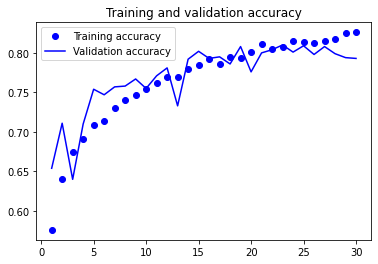

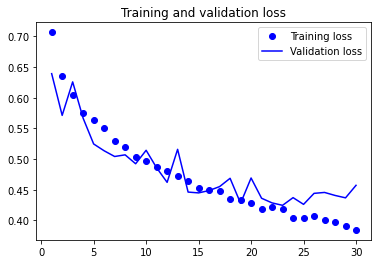

In [ ]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Evaluating the model on the Test set

In [ ]:
test_model = keras.models.load_model("convnet_from_scratch.keras_augment_4000")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 45ms/step - loss: 0.3880 - accuracy: 0.8340
Test accuracy: 0.834


Given below script is to use with pretrained model

In [ ]:
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c dogs-vs-cats
!unzip -qq dogs-vs-cats.zip
!unzip -qq train.zip

In [ ]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)
make_subset("test", start_index=0, end_index=500)
make_subset("validation", start_index=500, end_index=1000)
make_subset("train", start_index=1000, end_index=5000)

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)


In [ ]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

In [ ]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

In [ ]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

In [ ]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


Feature extraction together with data augmentation
Instantiating and freezing the VGG16 convolutional base

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

58900480/58889256 [==============================] - 0s 0us/step


Printing the list of trainable weights before and after freezing

In [ ]:
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

In [ ]:
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

Adding a data augmentation stage and a classifier to the convolutional base

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)


inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Evaluating the model on the test set



In [ ]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 19s 598ms/step - loss: 1.9534 - accuracy: 0.9790
Test accuracy: 0.979


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

Running the model on the trained model with optimization

In [ ]:
conv_base.summary()

In [ ]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)


inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

In [ ]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.Adam(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=15,
    validation_data=validation_dataset,
    callbacks=callbacks)

In [ ]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")